# Mask RCNN ResNext101 (masked)

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
import json
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import torchvision
import torchvision.transforms as T
from torchvision import transforms
from torchvision.datasets.coco import CocoDetection

from torchvision.models.detection import (
    maskrcnn_resnet50_fpn,
    MaskRCNN,
    FastRCNNPredictor
)
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.backbone_utils import (
    resnet_fpn_backbone,
    BackboneWithFPN
)

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as coco_mask


## Data Formation

In [ ]:
class COCOVehicleDataset(Dataset):
    def __init__(self, img_dir, ann_path, transforms=None):
        self.img_dir = img_dir
        self.transforms = transforms
        self.coco = COCO(ann_path)
        self.image_ids = list(self.coco.imgs.keys())

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, img_info['file_name'])
        img = Image.open(img_path).convert("RGB")

        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        boxes, labels, masks = [], [], []

        for ann in anns:
            if 'segmentation' in ann:
                x, y, w, h = ann['bbox']
                boxes.append([x, y, x + w, y + h])
                labels.append(1) 

               
                rle = coco_mask.frPyObjects(ann['segmentation'], img_info['height'], img_info['width'])
                mask = coco_mask.decode(rle)
                if len(mask.shape) == 3: 
                    mask = np.any(mask, axis=2).astype(np.uint8)
                masks.append(torch.as_tensor(mask, dtype=torch.uint8))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.stack(masks) if masks else torch.zeros((0, img.height, img.width), dtype=torch.uint8)

        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,
            "image_id": torch.tensor([img_id])
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.image_ids)


# Model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnext = torchvision.models.resnext101_32x8d(weights="DEFAULT")

backbone = torch.nn.Sequential(
    resnext.conv1,
    resnext.bn1,
    resnext.relu,
    resnext.maxpool,
    resnext.layer1,
    resnext.layer2,
    resnext.layer3,
    resnext.layer4,
)

in_channels_list = [256, 512, 1024, 2048]  
out_channels = 256

fpn_backbone = BackboneWithFPN(
    backbone,
    return_layers={"4": "0", "5": "1", "6": "2", "7": "3"},  
    in_channels_list=in_channels_list,
    out_channels=out_channels,
)


model = MaskRCNN(fpn_backbone, num_classes=2)  

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)

in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, out_channels, 2)

model.to(device)

for name, param in resnext.named_parameters():
    if "layer4" not in name:
        param.requires_grad = False


## Data Load

In [12]:
from torchvision import transforms as T

def get_transform(train=True):
    return T.Compose([T.ToTensor()])


In [13]:
train_dataset = COCOVehicleDataset(
    img_dir="/kaggle/input/traffic-dataset/traffic_wala_dataset/train/images",
    ann_path="/kaggle/input/coco-format-seg/train_coco_with_seg.json",
    transforms=get_transform(train=True)
)

val_dataset = COCOVehicleDataset(
    img_dir="/kaggle/input/traffic-dataset/traffic_wala_dataset/valid/images",
    ann_path="/kaggle/input/coco-format-seg/val_coco_with_seg.json",
    transforms=get_transform(train=False)
)


loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [14]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


## Training

In [15]:
import torch.optim as optim
from torch.optim import AdamW
params = [p for p in model.parameters() if p.requires_grad]
optimizer = AdamW(params, lr=0.0001, weight_decay=0.0001)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
num_epochs = 50


In [ ]:
from tqdm.notebook import tqdm
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    batch_losses = []
    mask_loss_total = 0.0

    print(f"\n Epoch [{epoch+1}/{num_epochs}]")
    for images, targets in tqdm(train_loader, desc="Training", leave=False):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()

        with autocast():
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        scaler.scale(losses).backward()
        scaler.step(optimizer)
        scaler.update()

        batch_losses.append(losses.item())
        total_loss += losses.item()

        if "loss_mask" in loss_dict:
            mask_loss_total += loss_dict["loss_mask"].item()

    avg_loss = total_loss / len(train_loader)
    avg_mask_loss = mask_loss_total / len(train_loader)

    print(f"🔁 Epoch [{epoch+1}/{num_epochs}] - Avg Loss: {avg_loss:.4f} | Avg Mask Loss: {avg_mask_loss:.4f}")
    lr_scheduler.step()



 Epoch [1/50]


/tmp/ipykernel_35/968140190.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Training:   0%|          | 0/268 [00:00<?, ?it/s]

/tmp/ipykernel_35/968140190.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


🔁 Epoch [1/50] - Avg Loss: 1.1779 | Avg Mask Loss: 0.4145

 Epoch [2/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

🔁 Epoch [2/50] - Avg Loss: 0.8163 | Avg Mask Loss: 0.2481

 Epoch [3/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

🔁 Epoch [3/50] - Avg Loss: 0.6759 | Avg Mask Loss: 0.2123

 Epoch [4/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

🔁 Epoch [4/50] - Avg Loss: 0.5905 | Avg Mask Loss: 0.1909

 Epoch [5/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

🔁 Epoch [5/50] - Avg Loss: 0.5344 | Avg Mask Loss: 0.1786

 Epoch [6/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

🔁 Epoch [6/50] - Avg Loss: 0.4871 | Avg Mask Loss: 0.1635

 Epoch [7/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

🔁 Epoch [7/50] - Avg Loss: 0.4510 | Avg Mask Loss: 0.1540

 Epoch [8/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

🔁 Epoch [8/50] - Avg Loss: 0.4178 | Avg Mask Loss: 0.1446

 Epoch [9/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

🔁 Epoch [9/50] - Avg Loss: 0.3829 | Avg Mask Loss: 0.1336

 Epoch [10/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

🔁 Epoch [10/50] - Avg Loss: 0.3655 | Avg Mask Loss: 0.1275

 Epoch [11/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

🔁 Epoch [11/50] - Avg Loss: 0.3453 | Avg Mask Loss: 0.1211

 Epoch [12/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

🔁 Epoch [12/50] - Avg Loss: 0.3222 | Avg Mask Loss: 0.1156

 Epoch [13/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

🔁 Epoch [13/50] - Avg Loss: 0.3111 | Avg Mask Loss: 0.1107

 Epoch [14/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

🔁 Epoch [14/50] - Avg Loss: 0.2947 | Avg Mask Loss: 0.1050

 Epoch [15/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

🔁 Epoch [15/50] - Avg Loss: 0.2844 | Avg Mask Loss: 0.1017

 Epoch [16/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

🔁 Epoch [16/50] - Avg Loss: 0.2475 | Avg Mask Loss: 0.0936

 Epoch [17/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

🔁 Epoch [17/50] - Avg Loss: 0.2269 | Avg Mask Loss: 0.0887

 Epoch [18/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

🔁 Epoch [18/50] - Avg Loss: 0.2183 | Avg Mask Loss: 0.0865

 Epoch [19/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

🔁 Epoch [19/50] - Avg Loss: 0.2132 | Avg Mask Loss: 0.0849

 Epoch [20/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

🔁 Epoch [20/50] - Avg Loss: 0.2085 | Avg Mask Loss: 0.0835

 Epoch [21/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

🔁 Epoch [21/50] - Avg Loss: 0.2029 | Avg Mask Loss: 0.0822

 Epoch [22/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

🔁 Epoch [22/50] - Avg Loss: 0.1989 | Avg Mask Loss: 0.0810

 Epoch [23/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

🔁 Epoch [23/50] - Avg Loss: 0.1945 | Avg Mask Loss: 0.0803

 Epoch [24/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

🔁 Epoch [24/50] - Avg Loss: 0.1898 | Avg Mask Loss: 0.0781

 Epoch [25/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

🔁 Epoch [25/50] - Avg Loss: 0.1877 | Avg Mask Loss: 0.0775

 Epoch [26/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

🔁 Epoch [26/50] - Avg Loss: 0.1851 | Avg Mask Loss: 0.0774

 Epoch [27/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

🔁 Epoch [27/50] - Avg Loss: 0.1815 | Avg Mask Loss: 0.0761

 Epoch [28/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

🔁 Epoch [28/50] - Avg Loss: 0.1799 | Avg Mask Loss: 0.0754

 Epoch [29/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

🔁 Epoch [29/50] - Avg Loss: 0.1764 | Avg Mask Loss: 0.0748

 Epoch [30/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

🔁 Epoch [30/50] - Avg Loss: 0.1760 | Avg Mask Loss: 0.0741

 Epoch [31/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

🔁 Epoch [31/50] - Avg Loss: 0.1682 | Avg Mask Loss: 0.0719

 Epoch [32/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

🔁 Epoch [32/50] - Avg Loss: 0.1697 | Avg Mask Loss: 0.0724

 Epoch [33/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

🔁 Epoch [33/50] - Avg Loss: 0.1693 | Avg Mask Loss: 0.0723

 Epoch [34/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

🔁 Epoch [34/50] - Avg Loss: 0.1688 | Avg Mask Loss: 0.0721

 Epoch [35/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

🔁 Epoch [35/50] - Avg Loss: 0.1672 | Avg Mask Loss: 0.0717

 Epoch [36/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

🔁 Epoch [36/50] - Avg Loss: 0.1659 | Avg Mask Loss: 0.0716

 Epoch [37/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

🔁 Epoch [37/50] - Avg Loss: 0.1662 | Avg Mask Loss: 0.0716

 Epoch [38/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

🔁 Epoch [38/50] - Avg Loss: 0.1665 | Avg Mask Loss: 0.0719

 Epoch [39/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

🔁 Epoch [39/50] - Avg Loss: 0.1646 | Avg Mask Loss: 0.0711

 Epoch [40/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

🔁 Epoch [40/50] - Avg Loss: 0.1650 | Avg Mask Loss: 0.0717

 Epoch [41/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

🔁 Epoch [41/50] - Avg Loss: 0.1655 | Avg Mask Loss: 0.0714

 Epoch [42/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

🔁 Epoch [42/50] - Avg Loss: 0.1640 | Avg Mask Loss: 0.0713

 Epoch [43/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

🔁 Epoch [43/50] - Avg Loss: 0.1655 | Avg Mask Loss: 0.0716

 Epoch [44/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

🔁 Epoch [44/50] - Avg Loss: 0.1642 | Avg Mask Loss: 0.0710

 Epoch [45/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

🔁 Epoch [45/50] - Avg Loss: 0.1623 | Avg Mask Loss: 0.0708

 Epoch [46/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

🔁 Epoch [46/50] - Avg Loss: 0.1626 | Avg Mask Loss: 0.0707

 Epoch [47/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

🔁 Epoch [47/50] - Avg Loss: 0.1638 | Avg Mask Loss: 0.0707

 Epoch [48/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

🔁 Epoch [48/50] - Avg Loss: 0.1610 | Avg Mask Loss: 0.0700

 Epoch [49/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

🔁 Epoch [49/50] - Avg Loss: 0.1636 | Avg Mask Loss: 0.0711

 Epoch [50/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

🔁 Epoch [50/50] - Avg Loss: 0.1640 | Avg Mask Loss: 0.0711


In [ ]:
torch.save(model.state_dict(), "mrcnnresNext101wmask_vehicle_detector.pth") #save Model

## Evaluation

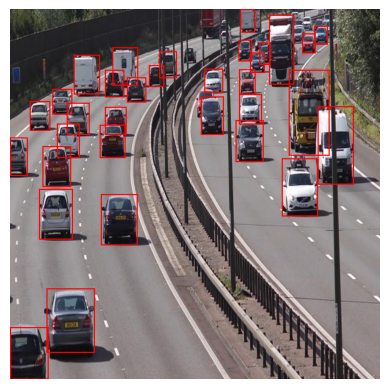

In [19]:
from PIL import ImageDraw

def infer_and_show(image_path):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    image_tensor = F.to_tensor(image).unsqueeze(0).to(device)

    with torch.no_grad():
        prediction = model(image_tensor)[0]

    image_draw = image.copy()
    draw = ImageDraw.Draw(image_draw)

    for box, score in zip(prediction["boxes"], prediction["scores"]):
        if score > 0.5:
            x1, y1, x2, y2 = box.cpu().numpy().astype(int)
            draw.rectangle(((x1, y1), (x2, y2)), outline="red", width=2)

    plt.imshow(image_draw)
    plt.axis("off")
    plt.show()

infer_and_show("/kaggle/input/traffic-dataset/traffic_wala_dataset/valid/images/10_mp4-25_jpg.rf.11c919cc683cc6a0d0a658be13483748.jpg")


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnext = torchvision.models.resnext101_32x8d(weights="DEFAULT")
backbone = torch.nn.Sequential(
    resnext.conv1,
    resnext.bn1,
    resnext.relu,
    resnext.maxpool,
    resnext.layer1,
    resnext.layer2,
    resnext.layer3,
    resnext.layer4,
)
in_channels_list = [256, 512, 1024, 2048]
out_channels = 256

fpn_backbone = BackboneWithFPN(
    backbone,
    return_layers={"4": "0", "5": "1", "6": "2", "7": "3"},
    in_channels_list=in_channels_list,
    out_channels=out_channels,
)

model = MaskRCNN(fpn_backbone, num_classes=2)

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)

in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, out_channels, 2)

model.load_state_dict(torch.load("mrcnnresNext101wmask_vehicle_detector.pth"))

model.to(device)
model.eval()


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (co

In [ ]:
def count_vehicles(image_path):
    from PIL import Image, ImageDraw
    import torchvision.transforms.functional as F

    image = Image.open(image_path).convert("RGB")
    image_tensor = F.to_tensor(image).unsqueeze(0).to(device)

    with torch.no_grad():
        prediction = model(image_tensor)[0]

    vehicle_count = sum(score.item() > 0.5 for score in prediction['scores'])
    print(f"🚌 Detected {vehicle_count} vehicles in image: {os.path.basename(image_path)}")

    draw = ImageDraw.Draw(image)
    for box, score in zip(prediction['boxes'], prediction['scores']):
        if score > 0.5:
            x1, y1, x2, y2 = box.int().tolist()
            draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
    display(image)


🚌 Detected 3 vehicles in image: 6_mp4-14_jpg.rf.a5099c3eeb2c707a2193c0efa467bb2a.jpg


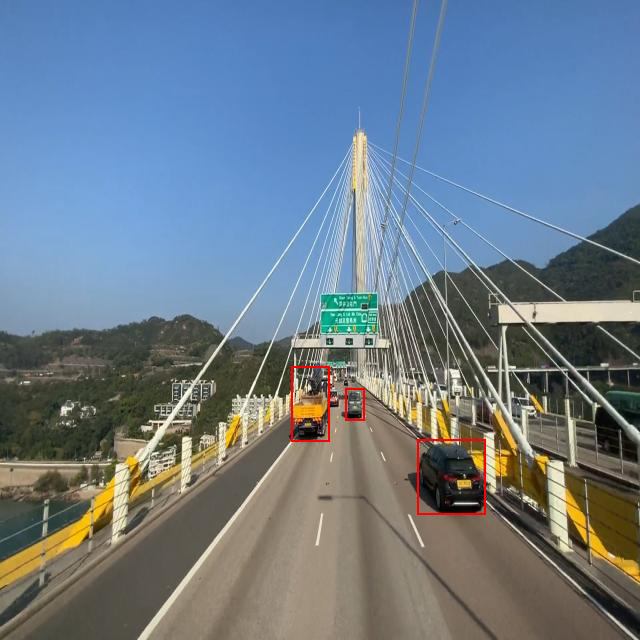

🚌 Detected 30 vehicles in image: 10_mp4-39_jpg.rf.af70092b5f2277f16d2703a4d59c3313.jpg


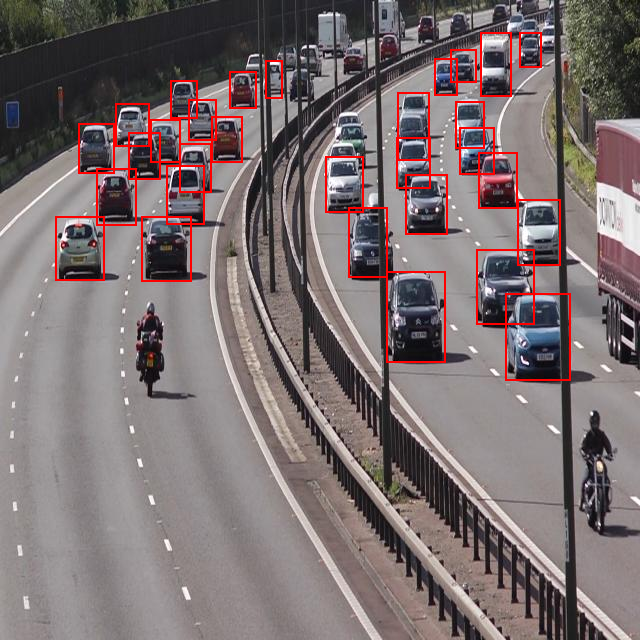

🚌 Detected 24 vehicles in image: 8_mp4-39_jpg.rf.bf01d183fca62e3316a0e4b31bfdf0da.jpg


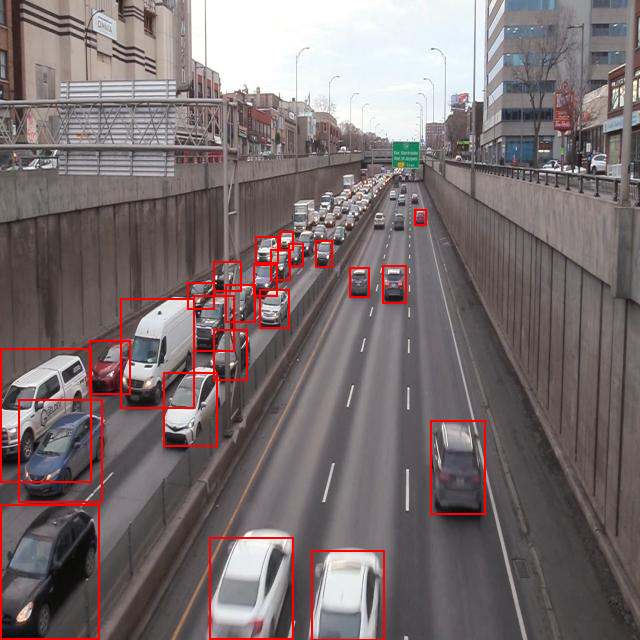

🚌 Detected 1 vehicles in image: 3_mp4-14_jpg.rf.6597c5732e0d554f1f07edb59abb4f8b.jpg


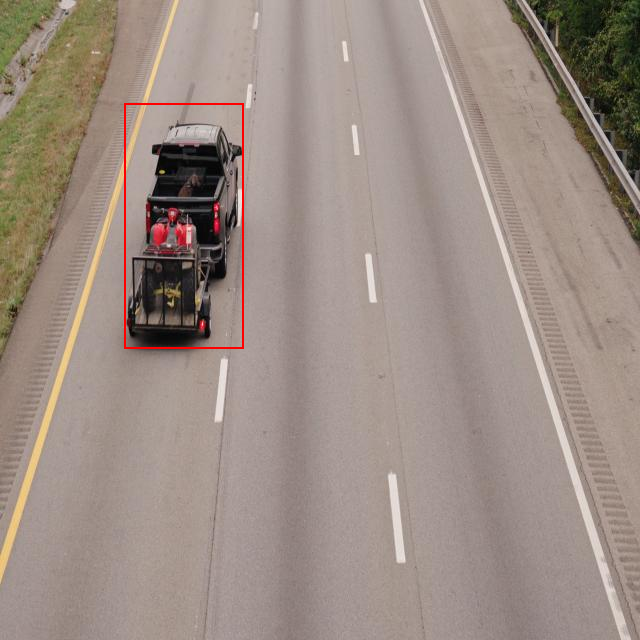

🚌 Detected 19 vehicles in image: test2_mp4-8_jpg.rf.c10dd559d44a868fd6f6877fd734815a.jpg


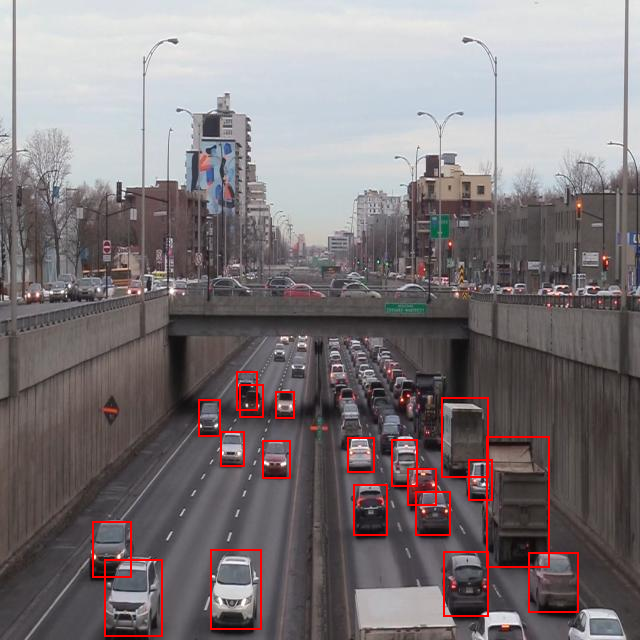

In [ ]:
import os
val_image_dir = "/kaggle/input/traffic-dataset/traffic_wala_dataset/valid/images"
for fname in os.listdir(val_image_dir)[20:25]: 
    count_vehicles(os.path.join(val_image_dir, fname))


## Metrics

In [ ]:
DEVICE      = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH  = "/kaggle/working/mrcnnresNext101wmask_vehicle_detector.pth"
IMG_DIR     = "/kaggle/input/traffic-dataset/traffic_wala_dataset/valid/images"
ANN_PATH    = "/kaggle/input/coco-format/val_coco.json"
CONF_THRESH = 0.3

resnext = torchvision.models.resnext101_32x8d(weights="DEFAULT")
backbone = torch.nn.Sequential(
    resnext.conv1,
    resnext.bn1,
    resnext.relu,
    resnext.maxpool,
    resnext.layer1,
    resnext.layer2,
    resnext.layer3,
    resnext.layer4,
)
in_channels_list = [256, 512, 1024, 2048]
out_channels = 256

fpn_backbone = BackboneWithFPN(
    backbone,
    return_layers={"4": "0", "5": "1", "6": "2", "7": "3"},
    in_channels_list=in_channels_list,
    out_channels=out_channels,
)

model = MaskRCNN(fpn_backbone, num_classes=2)

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)

in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, out_channels, 2)

model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE).eval()

coco_gt   = COCO(ANN_PATH)
img_ids   = coco_gt.getImgIds()
cat_ids   = coco_gt.getCatIds()
CAT_ID    = cat_ids[0]  


to_tensor = T.ToTensor()
preds = []

for img_id in img_ids:
    info = coco_gt.loadImgs(img_id)[0]
    img_path = os.path.join(IMG_DIR, info["file_name"])
    img = Image.open(img_path).convert("RGB")
    tensor = to_tensor(img).to(DEVICE).unsqueeze(0)

    with torch.no_grad():
        out = model(tensor)[0]

    boxes  = out["boxes"].cpu().numpy()
    scores = out["scores"].cpu().numpy()

    for box, score in zip(boxes, scores):
        if score < CONF_THRESH:
            continue
        x1, y1, x2, y2 = box
        preds.append({
            "image_id":    img_id,
            "category_id": CAT_ID,
            "bbox":        [float(x1), float(y1), float(x2 - x1), float(y2 - y1)],
            "score":       float(score)
        })

with open("predictions.json", "w") as f:
    json.dump(preds, f)

coco_dt   = coco_gt.loadRes("predictions.json")
coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.30s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.643
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.929
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.792
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.484
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.681
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.757
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.076
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.482
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

In [ ]:
!pip install -q deep_sort_realtime

In [ ]:
import cv2
import torch
import numpy as np
from torchvision import transforms as T
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from deep_sort_realtime.deepsort_tracker import DeepSort

# === CONFIG ===
VIDEO_PATH = "/kaggle/input/vidtryyy/56310-479197605_small.mp4"
MODEL_PATH = "/kaggle/working/mrcnnres101wmask_vehicle_detector.pth"
OUTPUT_PATH = "tracked_output_livecount.mp4"
CONF_THRESH = 0.5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Load Model ===
model = maskrcnn_resnet50_fpn(backbone_name="resnet101", weights="DEFAULT")
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE).eval()

# === Video Setup ===
cap = cv2.VideoCapture(VIDEO_PATH)
W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
FPS = cap.get(cv2.CAP_PROP_FPS)
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out_vid = cv2.VideoWriter(OUTPUT_PATH, fourcc, FPS, (W, H))

# === Tracker and Utils ===
transform = T.ToTensor()
tracker = DeepSort(max_age=30)
PIXELS_PER_METER = 10
ROI_LINE_Y = int(0.6 * H)

# === Counters ===
entry_count = 0
exit_count = 0
object_last_centers = {}

# === Main Loop ===
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img_tensor = transform(img_rgb).to(DEVICE).unsqueeze(0)

    with torch.no_grad():
        output = model(img_tensor)[0]

    detections = []
    for box, score in zip(output["boxes"], output["scores"]):
        if score >= CONF_THRESH:
            x1, y1, x2, y2 = box.int().tolist()
            w, h = x2 - x1, y2 - y1
            detections.append(([x1, y1, w, h], float(score), "vehicle"))

    tracks = tracker.update_tracks(detections, frame=frame)
    visible_vehicle_count = 0

    for track in tracks:
        if not track.is_confirmed():
            continue
        visible_vehicle_count += 1

        track_id = track.track_id
        x1, y1, x2, y2 = map(int, track.to_ltrb())
        cx, cy = (x1 + x2) // 2, (y1 + y2) // 2

        if track_id in object_last_centers:
            prev_cx, prev_cy = object_last_centers[track_id]
            if prev_cy < ROI_LINE_Y <= cy:
                entry_count += 1
            elif prev_cy > ROI_LINE_Y >= cy:
                exit_count += 1

            dist_px = np.hypot(cx - prev_cx, cy - prev_cy)
            speed = (dist_px * FPS) / PIXELS_PER_METER
        else:
            speed = 0

        object_last_centers[track_id] = (cx, cy)

        # Draw box & speed
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
        cv2.putText(frame, f"ID:{track_id} S:{speed:.1f}m/s", (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    # Overlay info
    cv2.line(frame, (0, ROI_LINE_Y), (W, ROI_LINE_Y), (255, 255, 0), 2)
    cv2.putText(frame, f"IN: {entry_count}  OUT: {exit_count}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)
    cv2.putText(frame, f"Vehicles in Frame: {visible_vehicle_count}", (10, 60),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    out_vid.write(frame)

cap.release()
out_vid.release()
print("✅ Saved: Tracked video with Live Vehicle Count")


## Thank You!